In [1]:
from math import sqrt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from feature_engine import missing_data_imputers as mdi
from feature_engine import discretisers as dsc
from feature_engine.categorical_encoders import OrdinalCategoricalEncoder, RareLabelCategoricalEncoder, MeanCategoricalEncoder
from feature_engine.outlier_removers import Winsorizer

## Process calendar.csv

In [2]:
data_calendar = pd.read_csv('./calendar.csv')
data_calendar = data_calendar.dropna(axis=0, subset=['listing_id', 'price'])
data_calendar['price'] = data_calendar['price'].str.replace('$','').str.replace(',','').astype(float)
data_calendar['date'] = pd.to_datetime(data_calendar['date'])
data_calendar = data_calendar[['listing_id','price','date']]
print(data_calendar.shape)
data_calendar.head()

(643037, 3)


,listing_id,price,date
365,3075044,65.0,2017-08-22
366,3075044,65.0,2017-08-21
367,3075044,65.0,2017-08-20
368,3075044,75.0,2017-08-19
369,3075044,75.0,2017-08-18


### Use average price of calendar.csv

In [3]:
data_calendar = data_calendar.groupby('listing_id').mean()
data_calendar['avg_price'] = data_calendar['price']
data_calendar.drop(columns=['price'], inplace=True)
data_calendar.head()

,avg_price
listing_id,
3353,35.204819
5506,147.267442
6695,197.407407
6976,65.000000
8792,154.000000


## Process listings.csv

In [4]:
data_listing = pd.read_csv('./listings.csv')
data_listing.index = data_listing['id']
data_listing = data_listing.drop(columns=['id'])

### Remove columns with 50% missing

In [5]:
print('Remove:', [data_listing.columns[data_listing.isnull().mean() > 0.5]])
data_listing = data_listing[data_listing.columns[data_listing.isnull().mean() < 0.5]]
data_listing.head()

Remove: [Index(['notes', 'neighbourhood_group_cleansed', 'square_feet', 'weekly_price',
       'monthly_price', 'security_deposit', 'has_availability', 'license',
       'jurisdiction_names'],
      dtype='object')]


,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,transit,...,review_scores_communication,review_scores_location,review_scores_value,requires_license,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
id,,,,,,,,,,,,,,,,,,,,,
12147973,https://www.airbnb.com/rooms/12147973,20160906204935,2016-09-07,Sunny Bungalow in the City,"Cozy, sunny, family home. Master bedroom high...",The house has an open and cozy feel at the sam...,"Cozy, sunny, family home. Master bedroom high...",none,"Roslindale is quiet, convenient and friendly. ...","The bus stop is 2 blocks away, and frequent. B...",...,NaN,NaN,NaN,f,f,moderate,f,f,1,NaN
3075044,https://www.airbnb.com/rooms/3075044,20160906204935,2016-09-07,Charming room in pet friendly apt,Charming and quiet room in a second floor 1910...,Small but cozy and quite room with a full size...,Charming and quiet room in a second floor 1910...,none,"The room is in Roslindale, a diverse and prima...",Plenty of safe street parking. Bus stops a few...,...,10.0,9.0,9.0,f,t,moderate,f,f,1,1.30
6976,https://www.airbnb.com/rooms/6976,20160906204935,2016-09-07,Mexican Folk Art Haven in Boston,"Come stay with a friendly, middle-aged guy in ...","Come stay with a friendly, middle-aged guy in ...","Come stay with a friendly, middle-aged guy in ...",none,The LOCATION: Roslindale is a safe and diverse...,"PUBLIC TRANSPORTATION: From the house, quick p...",...,10.0,9.0,10.0,f,f,moderate,t,f,1,0.47
1436513,https://www.airbnb.com/rooms/1436513,20160906204935,2016-09-07,Spacious Sunny Bedroom Suite in Historic Home,Come experience the comforts of home away from...,Most places you find in Boston are small howev...,Come experience the comforts of home away from...,none,Roslindale is a lovely little neighborhood loc...,There are buses that stop right in front of th...,...,10.0,10.0,10.0,f,f,moderate,f,f,1,1.00
7651065,https://www.airbnb.com/rooms/7651065,20160906204935,2016-09-07,Come Home to Boston,"My comfy, clean and relaxing home is one block...","Clean, attractive, private room, one block fro...","My comfy, clean and relaxing home is one block...",none,"I love the proximity to downtown, the neighbor...",From Logan Airport and South Station you have...,...,10.0,9.0,10.0,f,f,flexible,f,f,1,2.25


## Process the two merged data

In [6]:
df = pd.merge(data_calendar, data_listing, left_index=True, right_index=True)
print(df.shape)

(2906, 86)


### Select columns

In [7]:
cols_used = ['avg_price', #'host_response_rate', 
           'host_is_superhost', 'neighbourhood_cleansed',
           'zipcode', 'latitude', 'longitude', 'property_type', 'room_type',
           'accommodates', 'bathrooms', 'bedrooms',
           'beds', 'amenities', 'cleaning_fee', 'guests_included', 'extra_people',
            'minimum_nights', 'maximum_nights',
            # 'availability_30', 'availability_60', 'availability_365',
           'number_of_reviews', 'review_scores_rating', 'review_scores_accuracy',
            'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication',
            'review_scores_location', 'review_scores_value', 'requires_license', 
            'instant_bookable', 'cancellation_policy', 'reviews_per_month']

df = df[cols_used]
df.head()
print(df.shape)

(2906, 30)


### Clean zipcode

In [8]:
# print(data_listing['zipcode'].unique())
new_zipcode = []
for var in df['zipcode']:
    if isinstance(var, float): # nan is with type of float
        new_zipcode.append(var)
        continue 
    new_zipcode.append(var[:5])
df['zipcode'] = new_zipcode
# df['zipcode'].unique()

### Clean amenities

In [9]:
df['amenities'] = [x.replace('{','').replace('}','').replace('"','').split(',') 
                                 for x in df['amenities']]
mlb = MultiLabelBinarizer()
amenities = pd.DataFrame(mlb.fit_transform(df.pop('amenities')), 
                         columns=mlb.classes_, index=df.index)

# change type to categorical type for later processing
amenities = amenities.astype('O')

### Q1. What are the top 10 popular amenities offered?

There are 46 kinds of amenities in total.


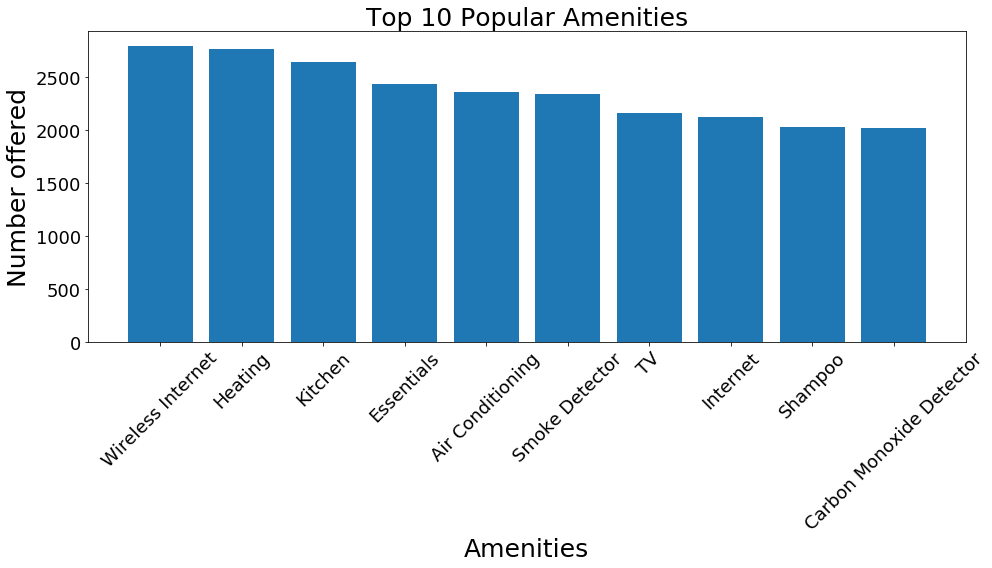

In [10]:
amenities_counts = amenities.sum().sort_values(ascending=False)
fig, ax = plt.subplots(figsize=(14,8))
plt.bar(amenities_counts[:10].index,amenities_counts[:10].values)
plt.title('Top 10 Popular Amenities', fontsize=25)
plt.xlabel('Amenities')
plt.ylabel('Number offered')
ax.set_xlabel(ax.get_xlabel(), fontsize=25)
ax.set_ylabel(ax.get_ylabel(), fontsize=25)
ax.tick_params(labelsize=18)
plt.xticks(rotation=45)
print('There are {0} kinds of amenities in total.'.format(len(amenities.columns)))
plt.tight_layout()
plt.savefig('./imgs/amenities.png')

### Clean cleaning_fee

In [11]:
df['cleaning_fee'] = df['cleaning_fee'].str.replace('$','').str.replace(',','').astype(float)
print(df['cleaning_fee'].head())

3353     50.0
5506     40.0
6695     70.0
6976      NaN
8792    250.0
Name: cleaning_fee, dtype: float64


### Clean extra_people

In [12]:
df['extra_people'] = df['extra_people'].str.replace('$','').astype(float)
print(df['extra_people'].head())

3353     0.0
5506     0.0
6695     8.0
6976    20.0
8792     0.0
Name: extra_people, dtype: float64


### Merge data

In [13]:
df = pd.merge(df, amenities, left_index=True, right_index=True)

### Q2. What is the most expensive zipcode in Boston?

652.683558177051
(30, 2)


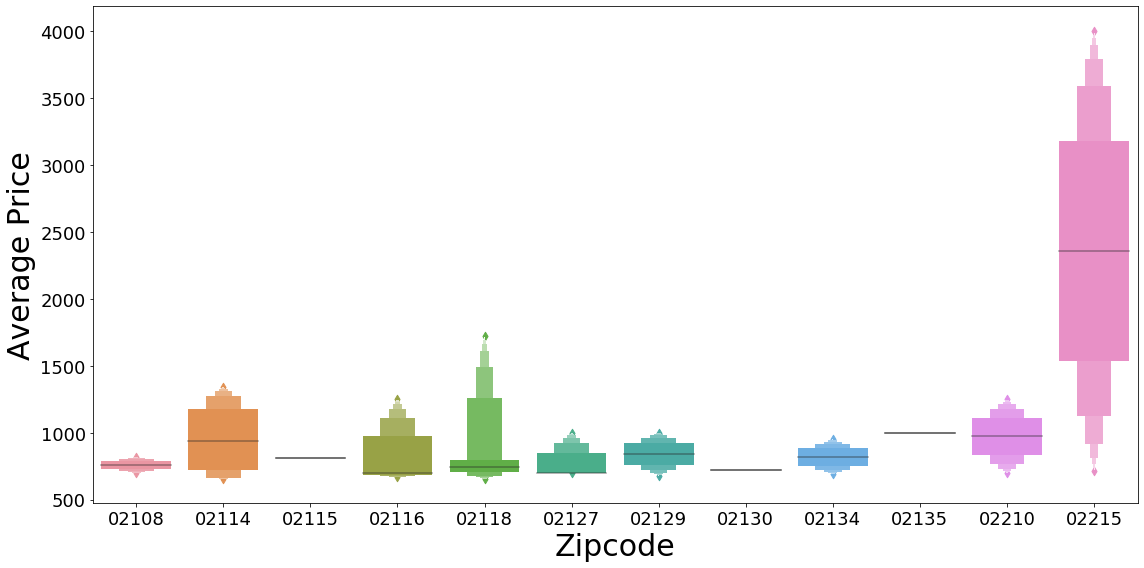

In [14]:
percentile = np.percentile(df['avg_price'], 99)
price_zipcode = df[(df['avg_price'] > percentile) ][['avg_price', 'zipcode']]
price_zipcode = price_zipcode.sort_values('avg_price', ascending=False)
fig, ax = plt.subplots(figsize=(16,8))
sns.boxenplot(price_zipcode['zipcode'], price_zipcode['avg_price'])
ax.set_xlabel(ax.get_xlabel(), fontsize=30)
ax.set_ylabel(ax.get_ylabel(), fontsize=30)
ax.tick_params(labelsize=18)
ax.set_xlabel('Zipcode')
ax.set_ylabel('Average Price')
plt.tight_layout()
ax.get_figure().savefig(f'./imgs/zipcodes.png')
print(percentile)
print(price_zipcode.shape)

There are 29 listings with price higher than $652.97, the price at 99 percentile. 


## Modeling Pre-processing

### Separate types of data

In [15]:
def separate_data(data):
    print(data.shape)
    discrete = [var for var in data.columns if data[var].dtype!='O' and var!='id' and data[var].nunique()<10]
    continuous = [var for var in data.columns if data[var].dtype!='O' and var!='id' and var not in discrete]

    # mixed
    # mixed = []

    # categorical
    categorical = [var for var in data.columns if data[var].dtype=='O'] # and var not in mixed]

    print('{} discrete variables'.format(len(discrete)))
    print('{} continuous variables'.format(len(continuous)))
    print('{} categorical variables'.format(len(categorical)))
    # print('{} mixed variables'.format(len(mixed)))
    
    assert(data.shape[1]==len(discrete) + len(continuous) + len(categorical))
    return discrete, continuous, categorical

In [16]:
discrete_listing, continuous_listing, categorical_listing = separate_data(df)

(2906, 75)
7 discrete variables
14 continuous variables
54 categorical variables


### Inspect variables cleaned 

In [17]:
df[discrete_listing].head()

,bedrooms,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value
3353,1.0,9.0,8.0,9.0,9.0,9.0,9.0
5506,1.0,9.0,10.0,10.0,10.0,9.0,10.0
6695,1.0,9.0,10.0,10.0,10.0,8.0,9.0
6976,1.0,10.0,9.0,10.0,10.0,9.0,10.0
8792,1.0,10.0,9.0,10.0,9.0,10.0,10.0


In [18]:
df[continuous_listing].head()

,avg_price,latitude,longitude,accommodates,bathrooms,beds,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,number_of_reviews,review_scores_rating,reviews_per_month
3353,35.204819,42.355017,-71.127590,1,1.0,1.0,50.0,1,0.0,7,365,34,90.0,0.38
5506,147.267442,42.329809,-71.095595,2,1.0,1.0,40.0,2,0.0,3,730,36,91.0,0.40
6695,197.407407,42.329941,-71.093505,4,1.0,2.0,70.0,2,8.0,3,730,47,95.0,0.54
6976,65.000000,42.292438,-71.135765,2,1.0,1.0,NaN,1,20.0,3,45,41,98.0,0.47
8792,154.000000,42.358497,-71.062011,3,1.0,1.0,250.0,0,0.0,30,365,18,91.0,0.21


In [19]:
df[categorical_listing].head()

,host_is_superhost,neighbourhood_cleansed,zipcode,property_type,room_type,requires_license,instant_bookable,cancellation_policy,,24-Hour Check-in,...,Smoke Detector,Smoking Allowed,Suitable for Events,TV,Washer,Washer / Dryer,Wheelchair Accessible,Wireless Internet,translation missing: en.hosting_amenity_49,translation missing: en.hosting_amenity_50
3353,f,Allston,02134,Apartment,Private room,f,f,strict,0,0,...,1,0,0,0,1,0,0,1,1,1
5506,f,Roxbury,02119,House,Private room,f,f,strict,0,0,...,0,0,0,1,1,0,0,1,0,0
6695,f,Roxbury,02119,Apartment,Entire home/apt,f,f,strict,0,1,...,1,0,0,1,1,0,0,1,0,0
6976,t,Roslindale,02131,Apartment,Private room,f,f,moderate,0,0,...,1,0,0,1,1,0,0,1,1,1
8792,f,Downtown,02108,Apartment,Entire home/apt,f,f,moderate,0,0,...,0,0,0,1,0,0,0,1,0,0


### Inspect missing values

In [20]:
# discrete
for var in discrete_listing:
    print(var, ": %.2f" %df[var].isnull().mean())

bedrooms : 0.00
review_scores_accuracy : 0.19
review_scores_cleanliness : 0.19
review_scores_checkin : 0.19
review_scores_communication : 0.19
review_scores_location : 0.19
review_scores_value : 0.19


In [21]:
# continuous
for var in continuous_listing:
    print(var, ": %.2f" %df[var].isnull().mean())

avg_price : 0.00
latitude : 0.00
longitude : 0.00
accommodates : 0.00
bathrooms : 0.00
beds : 0.00
cleaning_fee : 0.27
guests_included : 0.00
extra_people : 0.00
minimum_nights : 0.00
maximum_nights : 0.00
number_of_reviews : 0.00
review_scores_rating : 0.19
reviews_per_month : 0.18


In [22]:
# categorical
for var in categorical_listing:
    print(var, ": %.2f" %df[var].isnull().mean())

host_is_superhost : 0.00
neighbourhood_cleansed : 0.00
zipcode : 0.01
property_type : 0.00
room_type : 0.00
requires_license : 0.00
instant_bookable : 0.00
cancellation_policy : 0.00
 : 0.00
24-Hour Check-in : 0.00
Air Conditioning : 0.00
Breakfast : 0.00
Buzzer/Wireless Intercom : 0.00
Cable TV : 0.00
Carbon Monoxide Detector : 0.00
Cat(s) : 0.00
Dog(s) : 0.00
Doorman : 0.00
Dryer : 0.00
Elevator in Building : 0.00
Essentials : 0.00
Family/Kid Friendly : 0.00
Fire Extinguisher : 0.00
First Aid Kit : 0.00
Free Parking on Premises : 0.00
Free Parking on Street : 0.00
Gym : 0.00
Hair Dryer : 0.00
Hangers : 0.00
Heating : 0.00
Hot Tub : 0.00
Indoor Fireplace : 0.00
Internet : 0.00
Iron : 0.00
Kitchen : 0.00
Laptop Friendly Workspace : 0.00
Lock on Bedroom Door : 0.00
Other pet(s) : 0.00
Paid Parking Off Premises : 0.00
Pets Allowed : 0.00
Pets live on this property : 0.00
Pool : 0.00
Safety Card : 0.00
Shampoo : 0.00
Smoke Detector : 0.00
Smoking Allowed : 0.00
Suitable for Events : 0.00


In [23]:
# simply drop 1% of zipcode missing
df = df.dropna(axis=0, subset=['zipcode'])

# missing left
[var for var in df if df[var].isnull().sum()!=0]

['property_type',
 'bathrooms',
 'bedrooms',
 'beds',
 'cleaning_fee',
 'review_scores_rating',
 'review_scores_accuracy',
 'review_scores_cleanliness',
 'review_scores_checkin',
 'review_scores_communication',
 'review_scores_location',
 'review_scores_value',
 'reviews_per_month']

### Inspect distributions

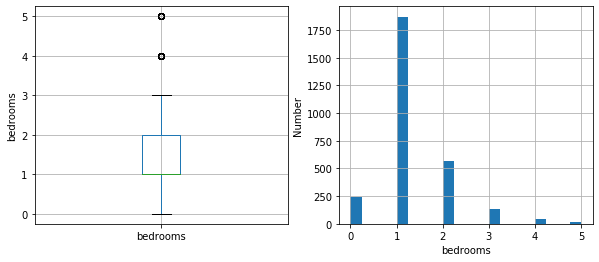

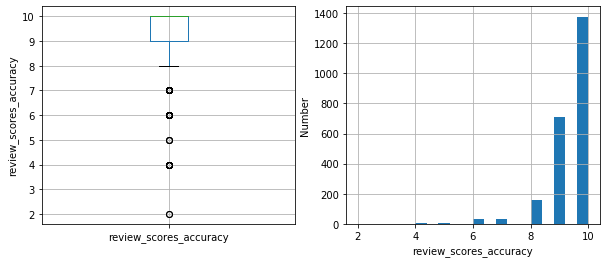

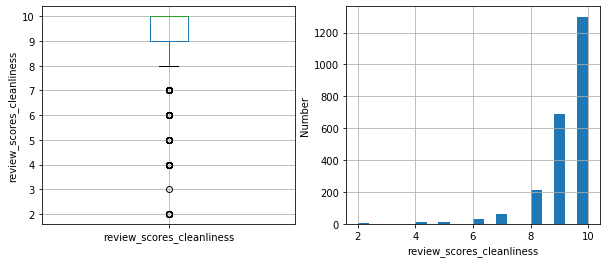

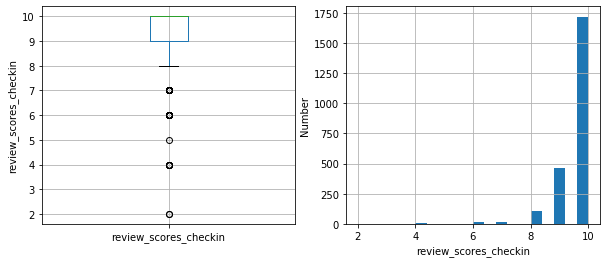

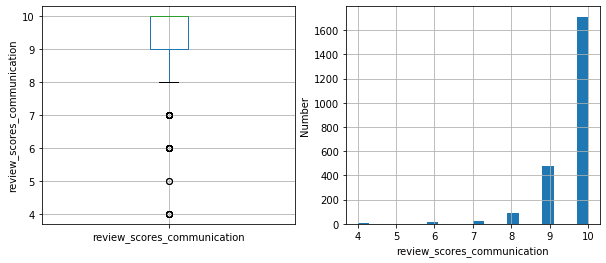

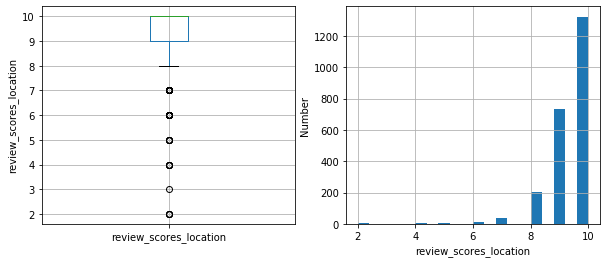

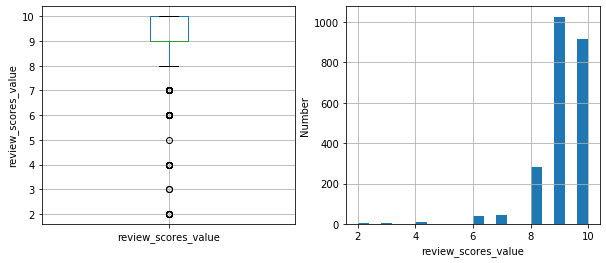

In [24]:
for var in discrete_listing:
    plt.figure(figsize=(10,4))
    plt.subplot(1, 2, 1)
    fig = df.boxplot(column=var)
    fig.set_title('')
    fig.set_ylabel(var)
    
    plt.subplot(1, 2, 2)
    fig = df[var].hist(bins=20)
    fig.set_ylabel('Number')
    fig.set_xlabel(var)
    plt.show()

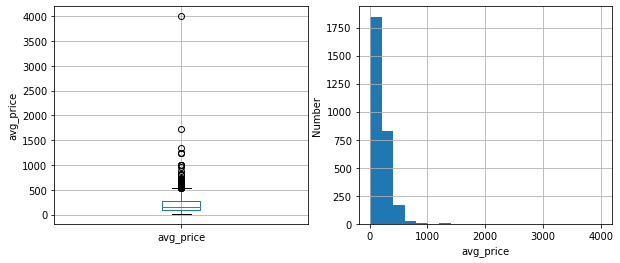

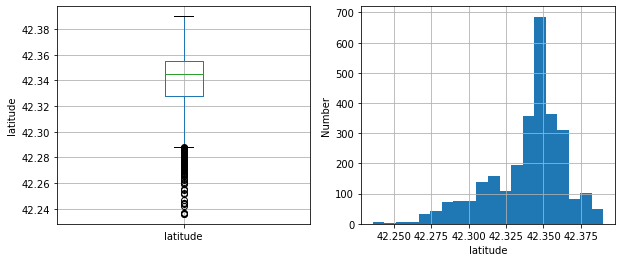

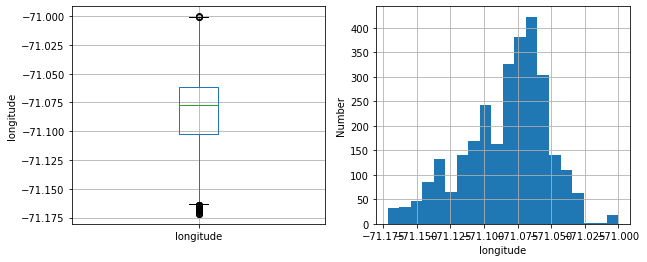

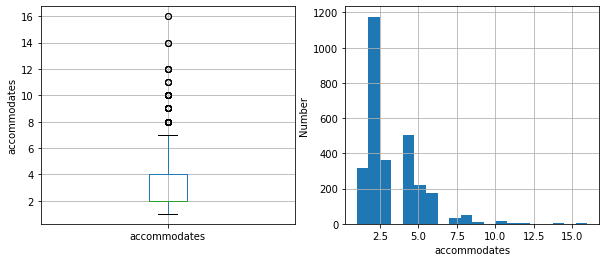

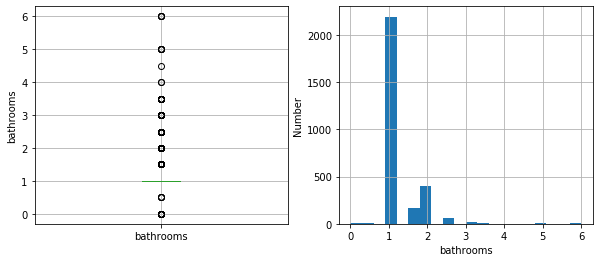

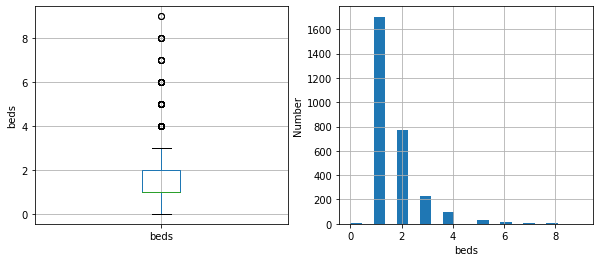

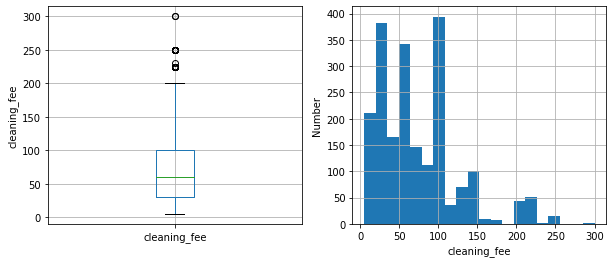

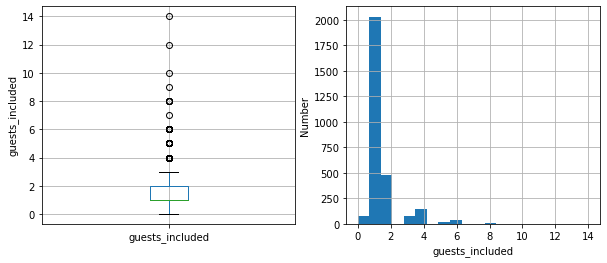

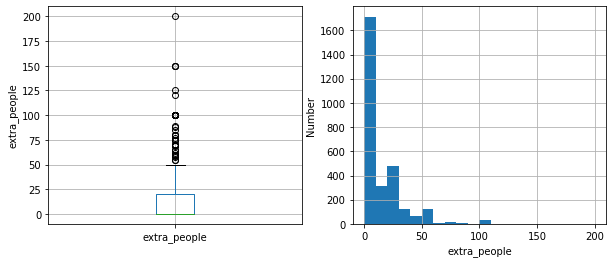

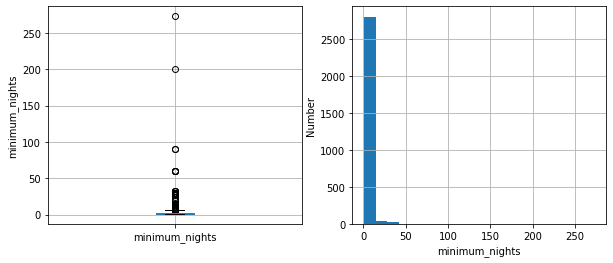

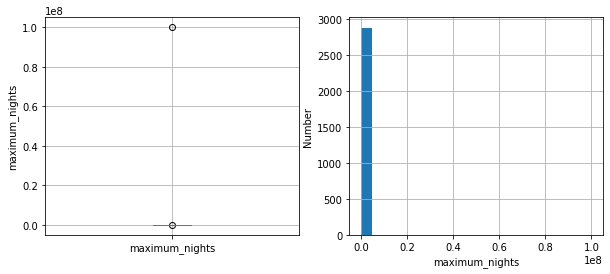

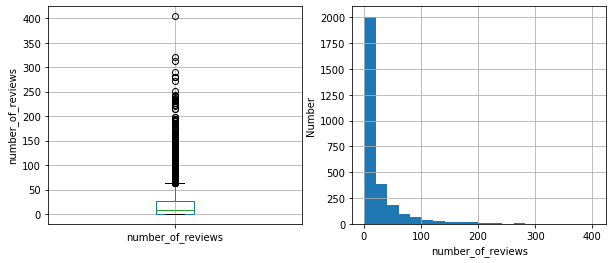

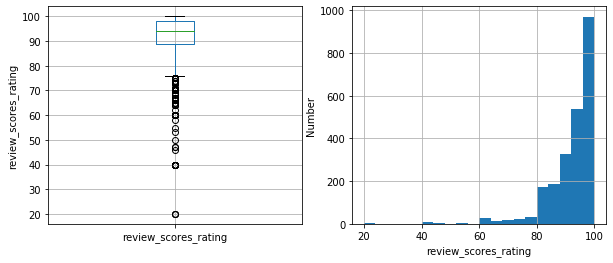

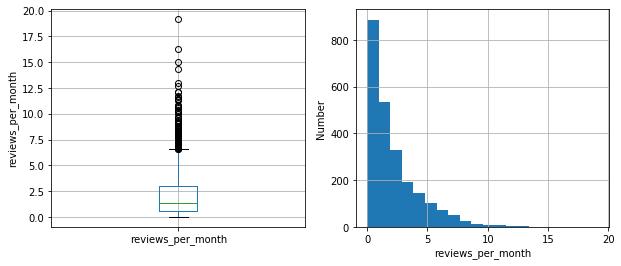

In [25]:
for var in continuous_listing:
    plt.figure(figsize=(10,4))
    plt.subplot(1, 2, 1)
    fig = df.boxplot(column=var)
    fig.set_title('')
    fig.set_ylabel(var)
    
    plt.subplot(1, 2, 2)
    fig = df[var].hist(bins=20)
    fig.set_ylabel('Number')
    fig.set_xlabel(var)
    plt.show()

* all show skewed distributions

## Modeling

In [26]:
continuous_listing.remove('avg_price')

In [27]:
# Let's separate into train and test set

X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['avg_price']),
                                                    df['avg_price'],
                                                    test_size=0.1,
                                                    random_state=0)
X_train.shape, X_test.shape

((2589, 74), (288, 74))

In [28]:
[var for var in df.columns if df[var].isnull().sum()!=0]

['property_type',
 'bathrooms',
 'bedrooms',
 'beds',
 'cleaning_fee',
 'review_scores_rating',
 'review_scores_accuracy',
 'review_scores_cleanliness',
 'review_scores_checkin',
 'review_scores_communication',
 'review_scores_location',
 'review_scores_value',
 'reviews_per_month']

### Lasso

In [29]:
pipe_lasso = Pipeline([
#     ('ws', Winsorizer(distribution='skewed', tail='both', fold=1.5, 
#                       variables=discrete_listing+continuous_listing)),
    
    ('mmi', mdi.MeanMedianImputer(imputation_method='mean',
                                            variables=discrete_listing+continuous_listing)),
    
    ('rle', RareLabelCategoricalEncoder(tol=0.05, n_categories=4,
                                       variables=categorical_listing)),
    ('oce', OrdinalCategoricalEncoder(encoding_method='ordered', variables=categorical_listing)),
#     ('mce', MeanCategoricalEncoder(variables=categorical_listing)),
#     ('ws', Winsorizer(distribution='skewed', tail='both', fold=1.5, 
#                       variables=discrete_listing+continuous_listing)),
    ('sts', StandardScaler()),
#     ('mms', MinMaxScaler()),
    
    ('lasso', Lasso(random_state=0))
     ])

param_grid = {
    'lasso__alpha': [0.1, 1, 10]
}

cv = GridSearchCV(pipe_lasso, param_grid, cv=3, iid=False, n_jobs=-1)
cv.fit(X_train, y_train)

X_train_preds = cv.predict(X_train)
X_test_preds = cv.predict(X_test)
# check model performance:

print('train mse: {}'.format(mean_squared_error(y_train, X_train_preds)))
print('train rmse: {}'.format(sqrt(mean_squared_error(y_train, X_train_preds))))
print('train r2: {}'.format(r2_score(y_train, X_train_preds)))
print()
print('test mse: {}'.format(mean_squared_error(y_test, X_test_preds)))
print('test rmse: {}'.format(sqrt(mean_squared_error(y_test, X_test_preds))))
print('test r2: {}'.format(r2_score(y_test, X_test_preds)))

train mse: 12043.020816379907
train rmse: 109.74069808589658
train r2: 0.5186743640953014

test mse: 12240.486649376156
test rmse: 110.63673282132005
test r2: 0.5097993733331249


### RandomForestRegressor

In [30]:
pipe_rf = Pipeline([
#     ('ws', Winsorizer(distribution='skewed', tail='both', fold=1.5, 
#                       variables=discrete_listing+continuous_listing)),
    
    ('mmi', mdi.MeanMedianImputer(imputation_method='median',
                                  variables=discrete_listing+continuous_listing)),
    
    ('rle', RareLabelCategoricalEncoder(tol=0.05, n_categories=4,
                                        variables=categorical_listing)),
    
    ('oce', OrdinalCategoricalEncoder(encoding_method='ordered', variables=categorical_listing)),
    
#     ('mce', MeanCategoricalEncoder(variables=categorical_listing)),
#     ('ws', Winsorizer(distribution='skewed', tail='both', fold=1.5, 
#                       variables=discrete_listing+continuous_listing)),
    
    ('sts', StandardScaler()),
    
#     ('mms', MinMaxScaler()),
    
    ('rf', RandomForestRegressor(random_state=0, criterion='mse'))
     ])

param_grid = {
    'rf__n_estimators': [200],
    'rf__min_samples_leaf':[2,3,4],
    'rf__min_samples_split': [2,3,4],
}

cv = GridSearchCV(pipe_rf, param_grid, cv=3, n_jobs=-1)
cv.fit(X_train, y_train)

X_train_preds = cv.predict(X_train)
X_test_preds = cv.predict(X_test)

print('train mse: {}'.format(mean_squared_error(y_train, X_train_preds)))
print('train rmse: {}'.format(sqrt(mean_squared_error(y_train, X_train_preds))))
print('train r2: {}'.format(r2_score(y_train, X_train_preds)))
print()
print('test mse: {}'.format(mean_squared_error(y_test, X_test_preds)))
print('test rmse: {}'.format(sqrt(mean_squared_error(y_test, X_test_preds))))
print('test r2: {}'.format(r2_score(y_test, X_test_preds)))

train mse: 6611.369270457596
train rmse: 81.3103269607102
train r2: 0.7357621840215045

test mse: 9174.864700934624
test rmse: 95.785514045364
test r2: 0.6325698025894123


### Question 3. What are the top 10 features correlated to price?

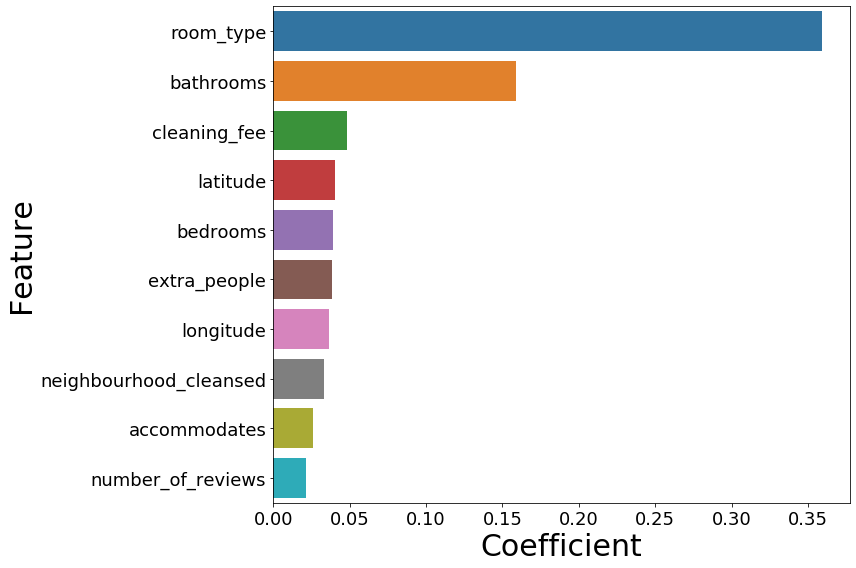

In [31]:
importance = pd.Series(cv.best_estimator_['rf'].feature_importances_)
importance.index = df.drop('avg_price', axis=1).columns
importance.sort_values(inplace=True, ascending=False)
importance = importance[:10]

feature_names = list(importance.index)
feature_coeffs = list(importance)
feature_coef_df = pd.DataFrame(list(zip(feature_names, feature_coeffs)), 
                               columns=['Feature', 'Coefficient']).sort_values('Coefficient', ascending=False)
fig, ax = plt.subplots(figsize=(12, 8))
ax = sns.barplot(x='Coefficient', y='Feature', data=feature_coef_df.iloc[:len(feature_names)+1], ax=ax)
ax.set_xlabel(ax.get_xlabel(), fontsize=30)
ax.set_ylabel(ax.get_ylabel(), fontsize=30)
ax.tick_params(labelsize=18)
plt.tight_layout()
ax.get_figure().savefig(f'./imgs/feature_importance.png')
